<a href="https://colab.research.google.com/github/jaiyue/Movie-Data-Analysis/blob/main/Movie_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Remove the movie dataset to ensure the next download succeeds

In [32]:
!rm -r the-movies-dataset

import every tool

In [33]:
!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast, json

upload kaggle.json file to download dataset

In [34]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hailingcai","key":"3581232c04d8591ebaeedf74bd3de296"}'}

In [35]:
od.download('https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset')

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


100%|██████████| 228M/228M [00:00<00:00, 416MB/s]


In [36]:
!ls /content/the-movies-dataset

credits.csv   links.csv        movies_metadata.csv  ratings_small.csv
keywords.csv  links_small.csv  ratings.csv


In [37]:
movies = pd.read_csv('/content/the-movies-dataset/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('/content/the-movies-dataset/ratings_small.csv')
credits = pd.read_csv('/content/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/content/the-movies-dataset/keywords.csv')

check data structue and the top 5 row

In [38]:
print(movies.head())
print(movies.info())
print(ratings.head())
print(credits.head())
print(keywords.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

 Clean dat: delete useless column

In [39]:
movies = movies.drop(['homepage', 'poster_path', 'tagline'], axis=1)

Separate all released movies from other movies

In [40]:
print(movies['status'].unique())

['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']


In [69]:
released_movies = movies[movies['status'] == 'Released'].copy()
other_movies = movies[movies['status'] != 'Released'].copy()

print("Released movies:", released_movies.shape)
print("Other movies:", other_movies.shape)

Released movies: (45014, 21)
Other movies: (452, 21)


Question:
How have the number of movies released/ average revenues/ average profit changed over the years?

Removed 78 rows with invalid release_date.
Movies year range: 1874 - 2017
Removed 39559 rows with invalid budget or revenue.


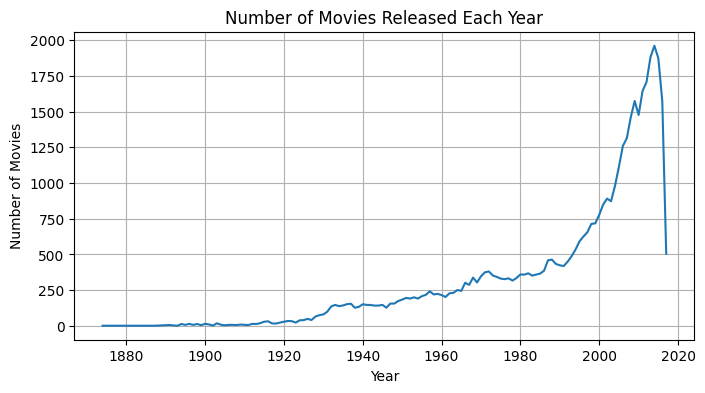

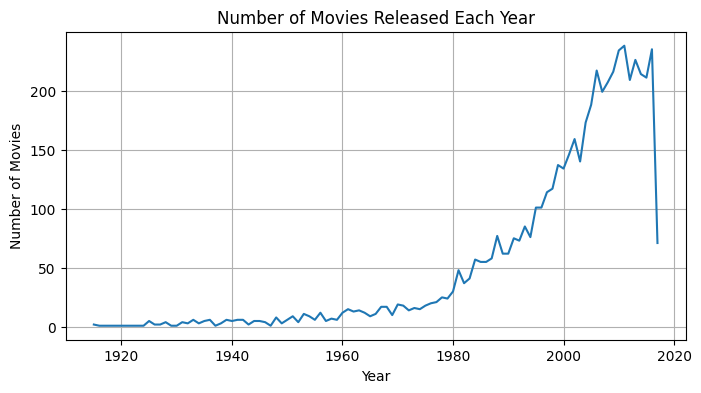

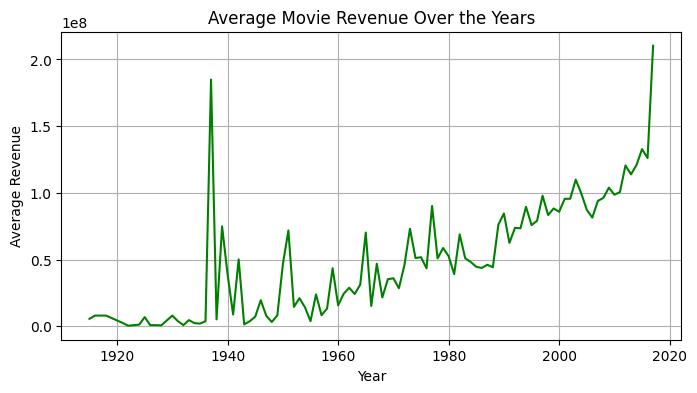

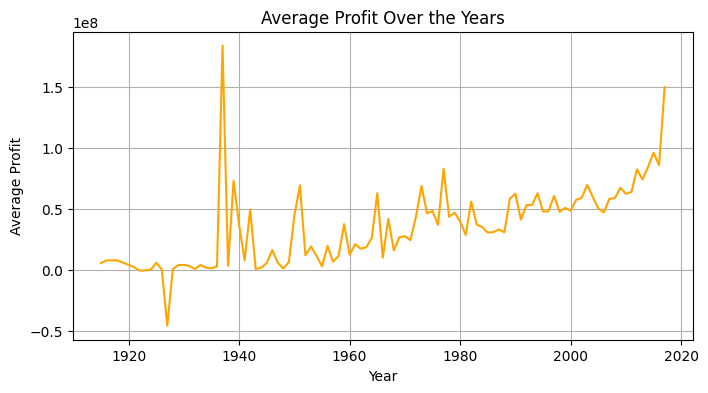

In [70]:
# Convert release date type
released_movies['release_date'] = pd.to_datetime(released_movies['release_date'], errors='coerce')

# Delete movies with invalid release date
original_count = len(released_movies)
released_movies = released_movies.dropna(subset=['release_date'])
cleaned_count = len(released_movies)
print(f"Removed {original_count - cleaned_count} rows with invalid release_date.")

# Extract release year
released_movies['release_year'] = released_movies['release_date'].dt.year

# Statistics on the number of movies released each year
movies_per_year = released_movies.groupby('release_year').size()
min_year = released_movies['release_year'].min()
max_year = released_movies['release_year'].max()
print(f"Movies year range: {min_year} - {max_year}")

# Convert budget and revenue to numerical types
released_movies['budget'] = pd.to_numeric(released_movies['budget'], errors='coerce')
released_movies['revenue'] = pd.to_numeric(released_movies['revenue'], errors='coerce')

# Delete invalid row
original_count = len(released_movies)
released_movies = released_movies.dropna(subset=['budget', 'revenue'])
released_movies = released_movies[(released_movies['budget'] > 0) & (released_movies['revenue'] > 0)]
cleaned_count = len(released_movies)
print(f"Removed {original_count - cleaned_count} rows with invalid budget or revenue.")

# Average revenue
avg_revenue_per_year = released_movies.groupby('release_year')['revenue'].mean()

# line chart of the number of movies released each year
plt.figure(figsize=(8,4))
movies_per_year.plot(kind='line')
plt.title("Number of Movies Released Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

movies_per_year = released_movies.groupby('release_year').size()
# line chart of the number of movies released each year with valid budget and revenue
plt.figure(figsize=(8,4))
movies_per_year.plot(kind='line')
plt.title("Number of Movies Released Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

# Average revenue line chart
plt.figure(figsize=(8,4))
avg_revenue_per_year.plot(kind='line', color='green')
plt.title("Average Movie Revenue Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Revenue")
plt.grid(True)
plt.show()

# Profit = Revenue - Budget
released_movies['profit'] = released_movies['revenue'] - released_movies['budget']
avg_ratio_per_year = released_movies.groupby('release_year')['profit'].mean()

# Profit line chart
plt.figure(figsize=(8,4))
avg_ratio_per_year.plot(kind='line', color='orange')
plt.title("Average Profit Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Profit")
plt.grid(True)
plt.show()

2.  What is the average runtime for movies in different genres?

In [44]:
released_movies_runtime = movies[movies['status'] == 'Released'].copy()
released_movies['runtime'] = pd.to_numeric(released_movies['runtime'], errors='coerce')
# Clean up movies with illegal runtime
released_movies = released_movies[released_movies['runtime'] > 0]

# Define the function and convert genres into strings
def getname(x):
    a = []
    for i in x:
        a.append(i['name'])
    return ','.join(a)

# String → Python object, extract "name"
released_movies['genres'] = released_movies['genres'].apply(ast.literal_eval)
released_movies['genres'] = released_movies['genres'].apply(getname)

# Split the type string of each movie into a list and expand it
released_movies['genre'] = released_movies['genres'].str.split(',')
released_movies = released_movies.explode('genre')

# Remove empty strings
released_movies['genre'] = released_movies['genre'].str.strip()
released_movies = released_movies[released_movies['genre'] != '']

num_genres = released_movies['genre'].nunique()
print(f"Number of unique genres: {num_genres}")

# Calculate average runtiime by 'genre'
avg_runtime = released_movies.groupby('genre')['runtime'].mean()
print("Average runtime (minutes) by genre:")
print(avg_runtime)


Number of unique genres: 20
Average runtime (minutes) by genre:
genre
Action             113.054494
Adventure          113.012500
Animation           90.344710
Comedy             102.686721
Crime              111.210465
Documentary        100.551724
Drama              116.073227
Family              98.225564
Fantasy            107.676471
Foreign            128.656250
History            138.306383
Horror              98.575085
Music              112.625000
Mystery            111.094808
Romance            113.765054
Science Fiction    108.293839
TV Movie            89.000000
Thriller           109.731691
War                129.632353
Western            122.426966
Name: runtime, dtype: float64


2.   What objective factors influence movie revenue?
